In [153]:
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import numpy as np
import os
from scipy.integrate import simpson
from scipy.signal import *
from sympy import symbols, Eq, solve, Interval


### Each file has its own Data object 

In [154]:
class Data:

    def __init__(self, filepath, filepath_categorized=True, temporal_avg_data=None):

        # small constructor for temporally averaged data
        # only generates a subset of the data associated with Data object
        # used for plotting purposes - include H or C in pseudo filepath
        # param temporal_avg_data = [x: avg of frequencies, y: avg of fft_result]
        if temporal_avg_data:
            self._frequencies = np.array(temporal_avg_data[0])
            self._frequencies_ppm = np.array(temporal_avg_data[0])
            self._fft_result = np.array(temporal_avg_data[1])
            if not filepath == "":
                self._filepath = filepath
                self.categorize_by_molecule()
            self.get_peaks()


        # actual constructor for Data object from input file
        # calls FFT and peak finding on data
        else:
            self._filepath = filepath
            if filepath_categorized:
                self.categorize_by_algorithm()
                self.categorize_by_state()
                self.categorize_by_P()
                self.categorize_by_molecule()
            if self._molecule == 'H':
                self._center_frequency = 3
                self._reference_frequency = 62.3748 * 10**6
            elif self._molecule == 'C':
                self._center_frequency = 73
                self._reference_frequency = 15.6858 * 10**6
            self.read_data()
            self.get_time_domain_data()
            self.get_frequency_domain_data()
            self.get_peaks()

    def read_data(self):
        data = np.loadtxt(self._filepath, delimiter=',')
        self._raw_data = data
        return data
    
    def categorize_by_P(self):
            if "P0" in self._filepath:
                self._P = 'P0'
            elif "P1" in self._filepath:
                self._P = 'P1'
            elif "P2" in self._filepath:
                self._P = 'P2'
            else:
                print(f"File is not in P category: {self._filepath}")

    def categorize_by_state(self):
        if self._algorithm_type == "DJ":
            if "U0" in self._filepath:
                self._state = 'U0'
            elif "U1" in self._filepath:
                self._state = 'U1'
            elif "U2" in self._filepath:
                self._state = 'U2'
            elif "U3" in self._filepath:
                self._state = 'U3'
            else:
                print(f"File does not have valid oracle: {self._filepath}")
        else: 
            if "00" in self._filepath:
                self._state = "00"
            elif "01" in self._filepath:
                self._state = "01"
            elif "10" in self._filepath:
                self._state = "10"
            elif "11" in self._filepath:
                self._state = "11"
            else:
                print(f"File is not in state category: {self._filepath}")

    def categorize_by_molecule(self):
        if "H" in self._filepath:
            self._molecule = "H"
        elif "C" in self._filepath:
            self._molecule = "C"
        else:
            print(f"File is not labeled H or C: {self._filepath}")

    def categorize_by_algorithm(self):
        if "DJ" in self._filepath:
            self._algorithm_type = "DJ"
        elif "G" in self._filepath:
            self._algorithm_type = "grover"
        elif "appx" in self._filepath:
            self._algorithm_type = "approx CNOT"
        elif "real" in self._filepath: 
            self._algorithm_type = "real CNOT"
        else:
            self._algorithm_type = "no gate"
        # else:
        #     print(f"File is not labeled with algorithm: {self._filepath}")

    def get_time_domain_data(self):
        time = self._raw_data[:, 0]  
        real_part = self._raw_data[:, 1]
        imaginary_part = self._raw_data[:, 2]
        complex_signal = real_part + 1j * imaginary_part
        self._time = time
        self._real_part = real_part
        self._imaginary_part = imaginary_part
        self._time_domain_data = complex_signal
        return (time, complex_signal)
    
    def get_frequency_domain_data(self):
        time = self._time
        N = len(time)
        dt = time[1] - time[0]
        fft_result = fft(self._time_domain_data)
        fft_result = fftshift(fft_result)
        frequencies = fftshift(fftfreq(N, dt))
        
        min_freq, max_freq = -0.2, 0.2
        frequency_range = (frequencies >= min_freq) & (frequencies <= max_freq)
        limited_frequencies = frequencies[frequency_range]
        limited_fft_result = fft_result[frequency_range]

        self._frequencies = limited_frequencies 
        self._frequencies_ppm = limited_frequencies
        # TODO Update to ppm
        self._fft_result = limited_fft_result
        return (limited_frequencies, limited_fft_result)
    
    def get_peaks(self, n_peaks=2):
        peaks, _ = find_peaks(np.abs(self._fft_result), distance=100)
        # select the n highest peaks based on their absolute magnitudes
        if len(peaks) > n_peaks:
            # if more than n peaks are found, choose the n highest based on the absolute values
            peaks = sorted(peaks, key=lambda peak: np.abs(self._fft_result[peak]), reverse=True)[:n_peaks]
        # retrieve original y values for the selected peaks
        self._peaks = [(self._frequencies_ppm[peak], self._fft_result[peak]) for peak in peaks]
        self._peaks.sort(key=lambda peak: peak[0]) # sort by frequency
        return self._peaks

    def fit_lorentzian(self, fit_range, peak_index):
        def lorentzian(f, f0, A, gamma,b):
            return  np.real (b+A * gamma / (1j*(f - f0) + gamma))
        
        fit_mask = (self._frequencies_ppm > (self._peaks[peak_index][0] - fit_range)) \
              & (self._frequencies_ppm < (self._peaks[peak_index][0] + fit_range))
        
        popt, pcov = curve_fit(lorentzian, self._frequencies_ppm[fit_mask], np.abs(self._fft_result)[fit_mask], 
                               p0=[self._peaks[peak_index][0], np.max(np.abs(self._fft_result)[fit_mask]), 0.1,0])
        
        fitted_f0, fitted_A, fitted_gamma, fitted_b = popt
        std_f0, std_A, std_gamma, std_b= np.sqrt(np.diag(pcov))

        if not hasattr(self, '_fitted_f0'):
            self._fitted_f0 = {}
        if not hasattr(self, '_fitted_A'):
            self._fitted_A = {}
        if not hasattr(self, '_fitted_gamma'):
            self._fitted_gamma = {}
        if not hasattr(self, '_fitted_b'):
            self._fitted_b = {}
        if not hasattr(self, '_std_f0'):
            self._std_f0 = {}
        if not hasattr(self, '_std_A'):
            self._std_A = {}
        if not hasattr(self, '_std_gamma'):
            self._std_gamma = {}
        if not hasattr(self, '_std_b'):
            self._std_b = {}

        self._fitted_f0[peak_index] = fitted_f0
        self._fitted_A[peak_index] = fitted_A
        self._fitted_gamma[peak_index] = fitted_gamma
        self._fitted_b[peak_index] = fitted_b

        self._std_f0[peak_index] = std_f0
        self._std_A[peak_index] = std_A
        self._std_gamma[peak_index] = std_gamma
        self._std_b[peak_index] = std_b
        
        lorentzian = lorentzian(self._frequencies_ppm[fit_mask], *popt)
        self._lorentzian = lorentzian

        self._popt = popt
        self._pcov = pcov
        return lorentzian
    
    def calculate_T2(self, peak_index="Time Domain Signal"):
        T2 = 1 / (self._fitted_gamma[peak_index])
        std_T2 = T2 * (self._std_gamma[peak_index] / self._fitted_gamma[peak_index])
        return (T2, std_T2)

    def plot_time_domain_data(self, label="Time Domain Signal"):
        plt.figure(figsize=(10, 6))
        plt.subplot(2, 1, 1)
        plt.plot(self._time, self._real_part, label='Real Part')
        plt.plot(self._time, self._imaginary_part, label='Imaginary Part', color='orange')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.title(label)
        # plt.savefig('FID_on_resonance_re.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        plt.legend()

    def plot_frequency_domain_data_one_peak(self, fit_range, peak_index):
        fit_mask = (self._frequencies_ppm > (self._peaks[peak_index][0] - fit_range)) \
              & (self._frequencies_ppm < (self._peaks[peak_index][0] + fit_range))

        fig = plt.figure(figsize=(10, 6))
        plt.plot(self._frequencies_ppm[fit_mask] + (self._center_frequency+1) 
                 * self._reference_frequency*1e3, np.abs(self._fft_result)[fit_mask],label='FFT Data')
        
        # plt.plot(self._frequencies[fit_mask] + (self._center_frequency+1)
        #          * self._reference_frequency*1e3, 
        #          self._lorentzian, label='Lorentzian Fit', color='red')
        
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Signal Strength')
        plt.title(f'Lorentzian Fit Around {self._peaks[peak_index][0] + (self._center_frequency+1) * self._reference_frequency * 1e3:.2f} kHz')
        plt.legend()
        # plt.savefig('FID_1H_25us_pluse_fit.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        # plt.show()

        return fig

    def plot_frequency_domain_data(self, label="Frequency Domain Signal"):
        fig = plt.figure(figsize=(4,2))
        plt.plot(self._frequencies_ppm, self._fft_result, label='FFT Data')      
        plt.axvline(x=0, color='r', linestyle='--', label=f'Center Freq of {self._molecule}')  # Red dotted line at x = 0
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Signal Strength')
        plt.title(label)
        plt.legend()
        # plt.savefig('FID_1H_25us_pluse_fit.png', dpi=300)  # Saves the figure as a PNG file with 300 dpi
        plt.show()
        return fig
        
    def integrate_peak(self, peak_index, integration_range):
        current_peak_frequency = self._peaks[peak_index][0]
        lower_bound = current_peak_frequency - integration_range
        upper_bound = current_peak_frequency + integration_range
        integration_mask = (self._frequencies_ppm > lower_bound) & (self._frequencies_ppm < upper_bound)
        real_integ_y_values = [y.real for y in (self._fft_result[integration_mask])]
        integ_x_values = self._frequencies_ppm[integration_mask]

        integrated_value = simpson(y=real_integ_y_values, x=integ_x_values)
        return integrated_value

    def phase_180_deg(self):
        phase_flip =  -1 * self._frequencies 
        phase_flip_ppm = -1 * self._frequencies_ppm
        self._frequencies = phase_flip
        self._frequencies_ppm = phase_flip_ppm

    def flip_about_X(self):
        phase_flip =  -1 * self._fft_result
        self._fft_result = phase_flip

### Initialize all Data in folder to an organized map

In [155]:
# make Data objects for all files in directory and categorize
def initialize_data(directory_path):
    data = []
    for file in os.listdir(directory_path):
        file_path = os.path.join(directory_path, file)
        if os.path.isfile(file_path):
            data_object = Data(file_path, filepath_categorized=True)
            data.append(data_object)
    categorized_data = categorize_data(data)
    return categorized_data

# sort data in a map - access by calling mymap[algorithm][H or C][state or oracle]
def categorize_data(all_data):
    categorized_data = {}
    for data in all_data:
        algorithm_type = data._algorithm_type
        molecule = data._molecule
        state = data._state
        P_type = data._P
        
        if algorithm_type not in categorized_data:
            categorized_data[algorithm_type] = {}
        if molecule not in categorized_data[algorithm_type]:
            categorized_data[algorithm_type][molecule] = {}
        if state not in categorized_data[algorithm_type][molecule]:
            categorized_data[algorithm_type][molecule][state] = {}
        if P_type in categorized_data[algorithm_type][molecule][state]:
            raise ValueError(f"Error: More than one file for {algorithm_type}, {molecule}, {state}, {P_type}")
        else:
            categorized_data[algorithm_type][molecule][state][P_type] = data
    
    return categorized_data


### Data Analysis Functions

In [156]:
def sum_P0_P1_P2(P0_spectra, P1_spectra, P2_spectra):
    a = P0_spectra[0] + P1_spectra[0] + P2_spectra[0]
    b = P0_spectra[1] + P1_spectra[1] + P2_spectra[1]
    c = P0_spectra[2] + P1_spectra[2] + P2_spectra[2]
    d = P0_spectra[3] + P1_spectra[3] + P2_spectra[3]

    return a,b,c,d


def plot_spectra(spectra_abcd, label, show=True):
  a,b,c,d = spectra_abcd
  x = ['1H peak 2', '1H peak 1', '13C peak 2', '13C peak 1']
  y = [b-d, a-c, c-d, a-b]

  if show:
    plt.figure(figsize=(4,2))
    plt.bar(x, y)
    plt.xlabel('Frequency')
    plt.ylabel('Signal Amplitude')
    plt.grid(True)
    plt.title(label)
    plt.show()

  return y


def solve_linear_abcd(peaks, state):
    peak1, peak2, peak3, peak4 = peaks
    A = np.array([
        [0, 1, 0, -1],  # for equation b-d = v1
        [1, 0, -1, 0],  # for equation a-c = v2
        [0, 0, 1, -1],  # for equation c-d = v3
        [1, -1, 0, 0]   # for equation a-b = v4
    ])

    B = np.array([peak1, peak2, peak3, peak4])

    # solve linear equations using least squares
    x, residuals, rank, s = np.linalg.lstsq(A, B, rcond=None)

    print(f"Solving for a,b,c,d for|{state}> is approximately:", x.real)


def average_spectral_data_Ps(data_map, algorithm, molecule, state, plot=False):
    # extract algorithm type from the map, they should be the same for all
    algorithm_type = next(iter(data_map))

    y_values = []
    x_values = []

    for P, data in data_map[algorithm][molecule][state].items():
        y_values.append(data._fft_result)
        x_values.append(data._frequencies_ppm)

    if not len(y_values) and len(x_values) == 3:
       print(f"All 3 P data is not available for {algorithm}, {molecule}, {state}")

    y_average = [sum(elements) / 3 for elements in zip(*y_values)]

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x_values[0], y_average, label='FFT Data')        
        plt.xlabel('Frequency (kHz)')
        plt.ylabel('Signal Strength')
        plt.title(f'Frequency Domain Signal')
        plt.legend()
        plt.show()

    return x_values[0], y_average

# def rho_from_peaks(peaks):
#     peak1 = peaks[0]
#     peak2 = peaks[1]
#     # Define the variables
#     a = symbols('a', real=True, domain=Interval(0, 1))
#     b = symbols('b', real=True, domain=Interval(0, 1))
#     c = symbols('c', real=True, domain=Interval(0, 1))
#     d = symbols('d', real=True, domain=Interval(0, 1))

#     # Define the equations based on the input
#     eq1 = Eq(a - c, peak1)
#     eq2 = Eq(b - d, peak2)
#     eq3 = Eq(a + b + c + d, 1)
#     eq4 = Eq((a+c)/(b+d),  peak1/peak2)

#     # Solve the equations
#     solutions = solve((eq1, eq2, eq3, eq4), (a, b, c, d), dict=True)
    
    # return solutions[0][a], solutions[0][b], solutions[0][c], solutions[0][d]



def rho_from_peaks(peaks):
    P0_peak1 = peaks[0]
    P0_peak2 = peaks[1]
    P1_peak1 = peaks[2]
    P1_peak2 = peaks[3]

    # Define the variables
    a = symbols('a', real=True, positive=True)
    b = symbols('b', real=True, positive=True)
    c = symbols('c', real=True, positive=True)
    d = symbols('d', real=True, positive=True)

    # Define the equations based on the input
    eq1 = Eq(b - d, P0_peak1)
    eq2 = Eq(a - c, P0_peak2)
    eq3 = Eq(d - c, P1_peak1)
    eq4 = Eq(a - b, P1_peak2)

    # Solve the equations
    solutions = solve((eq1, eq2, eq3, eq4), (a, b, c, d), dict=True)
    
    return solutions



### Real CNOT Data Processing and Analysis

In [157]:
folder_path = "/workspaces/nmr_lab3/cnot2"
CNOT_data_map = initialize_data(folder_path)
# print(CNOT_data_map)

# TO TEST ANY SINGLE DATA FILE
# test_cnot_data = CNOT_data_map['real CNOT']['H']['11']['P0']
# test_cnot_data.plot_frequency_domain_data()
# print(test_cnot_data.integrate_peak(0, 0.02))
# print(test_cnot_data.integrate_peak(1, 0.02))


/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/codespace/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


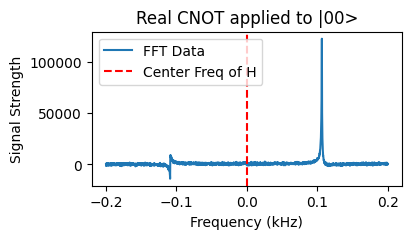

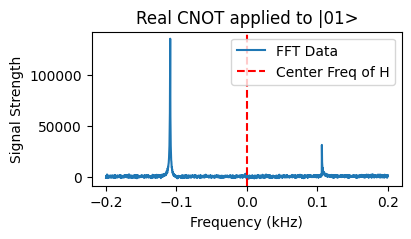

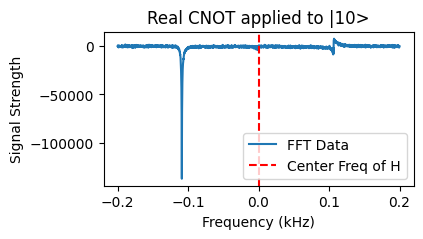

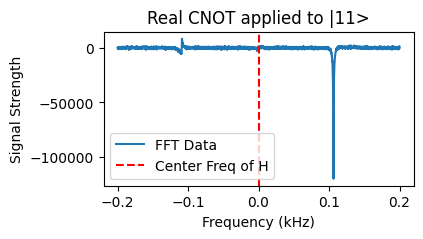

In [158]:
target_qubits = ['H']
states = ['00', '01', '10', '11']
real_cnot_peaks = []

for i, state in enumerate(states):
    real_cnot_peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(CNOT_data_map, 'real CNOT', qubit, state)
        avg_data = Data(qubit, temporal_avg_data=xy_average)
        avg_data.plot_frequency_domain_data(f"Real CNOT applied to |{state}>")
        real_cnot_peaks[i].append(avg_data.integrate_peak(0, 0.02))
        real_cnot_peaks[i].append(avg_data.integrate_peak(1, 0.02))
        # rho_vals = rho_from_peaks(real_cnot_peaks[i])
        # plot_spectra(rho_vals, label=state)

# If we have Carbon and Hydrogen we can use this to solve for ABCD
# solve_linear_abcd(peaks[0], '00')

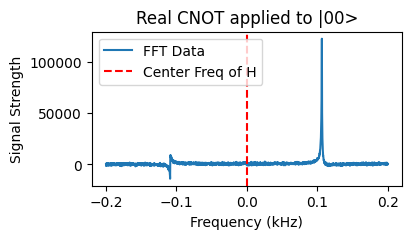

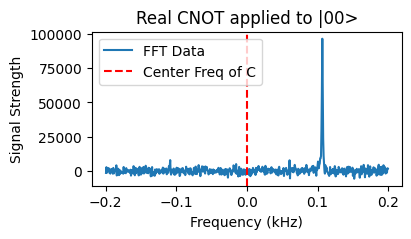

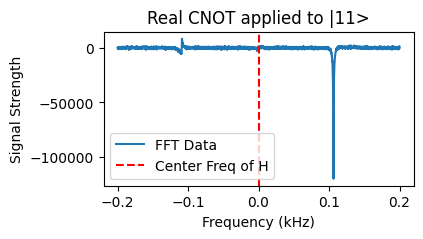

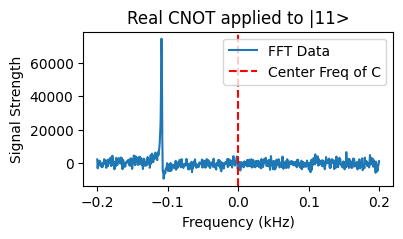

Solving for a,b,c,d for|00> is approximately: [169.62929825 -43.26121818 -62.7545672  -63.61351288]
Solving for a,b,c,d for|11> is approximately: [-44.98408127 -46.25739789 123.29739161 -32.05591244]


In [159]:
target_qubits = ['H', 'C']
states = ['00', '11']
real_cnot_peaks = []

for i, state in enumerate(states):
    real_cnot_peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(CNOT_data_map, 'real CNOT', qubit, state)
        avg_data = Data(qubit, temporal_avg_data=xy_average)
        avg_data.plot_frequency_domain_data(f"Real CNOT applied to |{state}>")
        real_cnot_peaks[i].append(avg_data.integrate_peak(0, 0.02))
        real_cnot_peaks[i].append(avg_data.integrate_peak(1, 0.02))

# If we have Carbon and Hydrogen we can use this to solve for ABCD
solve_linear_abcd(real_cnot_peaks[0], '00')
solve_linear_abcd(real_cnot_peaks[1], '11')

### Approximate CNOT

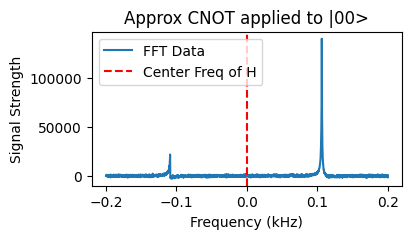

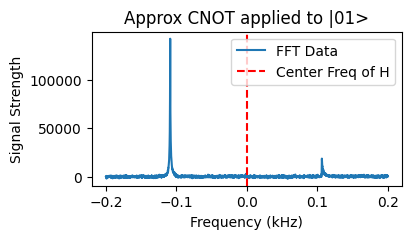

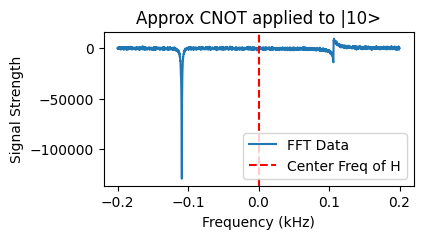

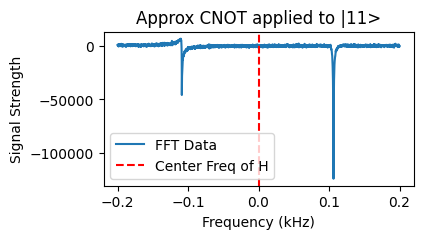

In [160]:
target_qubits = ['H']
states = ['00', '01', '10', '11']
approx_cnot_peaks = []

for i, state in enumerate(states):
    approx_cnot_peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(CNOT_data_map, 'approx CNOT', qubit, state)
        avg_data = Data(qubit, temporal_avg_data=xy_average)
        avg_data.plot_frequency_domain_data(f"Approx CNOT applied to |{state}>")
        approx_cnot_peaks[i].append(avg_data.integrate_peak(0, 0.02))
        approx_cnot_peaks[i].append(avg_data.integrate_peak(1, 0.02))

### Deutsch Josza Data Processing and Analysis

In [161]:
DJ_folder_path = "/workspaces/nmr_lab3/dj_data3"
DJ_data_map = initialize_data(DJ_folder_path)

# TO TEST ANY SINGLE FILE:
# test_dj_data = DJ_data_map['DJ']['H']['U1']['P0']
# test_dj_data.plot_time_domain_data()
# test_dj_data.plot_frequency_domain_data()
# print(test_dj_data.integrate_peak(0, 0.02))
# print(test_dj_data.integrate_peak(1, 0.02))


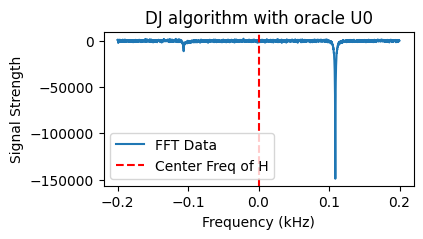

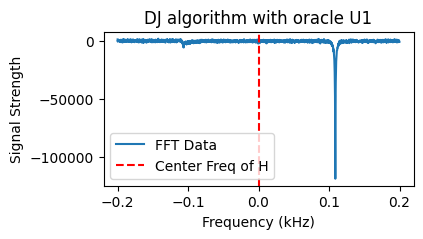

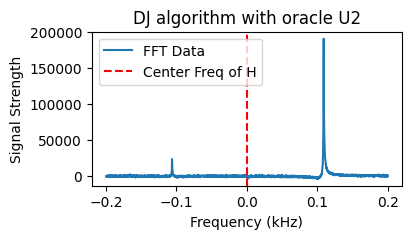

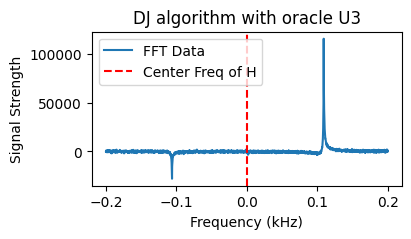

In [162]:
target_qubits = ['H']
oracles = ['U0', 'U1', 'U2', 'U3']
peaks = []

for i, oracle in enumerate(oracles):
    peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(DJ_data_map, 'DJ', qubit, oracle)

        avg_data = Data(qubit, temporal_avg_data=xy_average)
        avg_data.phase_180_deg() # we forgot to apply phase to hydrogen
        avg_data.plot_frequency_domain_data(f"DJ algorithm with oracle {oracle}")

        peaks[i].append(avg_data.integrate_peak(0, 0.02))
        peaks[i].append(avg_data.integrate_peak(1, 0.02))


### Grover Data Processing and Analysis

{'grover': {'H': {'00': {'P2': <__main__.Data object at 0x7fd02d909c30>, 'P1': <__main__.Data object at 0x7fd02e326ce0>, 'P0': <__main__.Data object at 0x7fd02d975420>}}}}


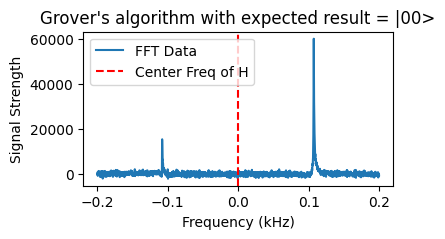

In [163]:
grover_folder_path = "/workspaces/nmr_lab3/grover1time00"
grover_data_map = initialize_data(grover_folder_path)
print(grover_data_map)

target_qubits = ['H']
oracles = ['00']

peaks = []

for i, oracle in enumerate(oracles):
    peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(grover_data_map, 'grover', qubit, oracle)
        avg_data = Data(qubit, temporal_avg_data=xy_average)
        avg_data.plot_frequency_domain_data(f"Grover's algorithm with expected result = |{oracle}>")
        peaks[i].append(avg_data.integrate_peak(0, 0.02))
        peaks[i].append(avg_data.integrate_peak(1, 0.02))


### Grover n Times on |00>

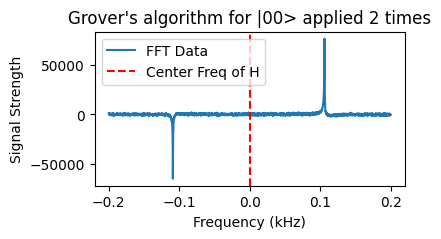

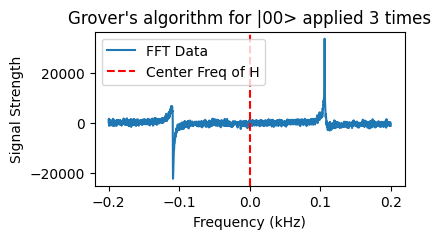

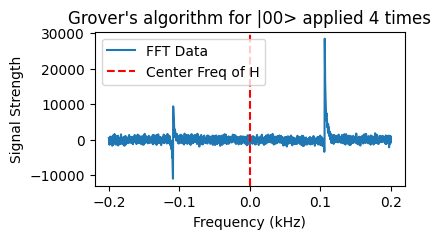

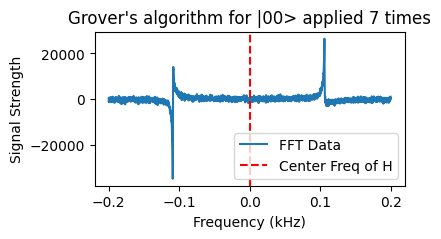

In [164]:
grover_ntimes_folder_paths = []
grover_ntimes_folder_paths.append((2, "/workspaces/nmr_lab3/grover2times"))
grover_ntimes_folder_paths.append((3, "/workspaces/nmr_lab3/grover3times_2"))
grover_ntimes_folder_paths.append((4, "/workspaces/nmr_lab3/grover4times"))
grover_ntimes_folder_paths.append((7, "/workspaces/nmr_lab3/grover7times"))

for n, grover_folder_path in grover_ntimes_folder_paths:
    grover_data_map = initialize_data(grover_folder_path)
    target_qubits = ['H']
    oracles = ['00']
    peaks = []

    for i, oracle in enumerate(oracles):
        peaks.append([])
        for qubit in target_qubits:
            xy_average = average_spectral_data_Ps(grover_data_map, 'grover', qubit, oracle)
            avg_data = Data(qubit, temporal_avg_data=xy_average)
            avg_data.plot_frequency_domain_data(f"Grover's algorithm for |{oracle}> applied {n} times")
            peaks[i].append(avg_data.integrate_peak(0, 0.02))
            peaks[i].append(avg_data.integrate_peak(1, 0.02))


### Initial State Preparation

In [165]:
initial_state_folder_path = "/workspaces/nmr_lab3/initial_state_prep"
initial_state_data_map = initialize_data(initial_state_folder_path)
print(initial_state_data_map)

{'no gate': {'H': {'11': {'P1': <__main__.Data object at 0x7fd02dc7a1d0>, 'P2': <__main__.Data object at 0x7fd02dfb87c0>, 'P0': <__main__.Data object at 0x7fd02e7f62c0>}, '01': {'P2': <__main__.Data object at 0x7fd02dda0af0>, 'P0': <__main__.Data object at 0x7fd02e7f7250>, 'P1': <__main__.Data object at 0x7fd02e51a2c0>}, '00': {'P0': <__main__.Data object at 0x7fd02e51a500>, 'P2': <__main__.Data object at 0x7fd02e3504c0>, 'P1': <__main__.Data object at 0x7fd02dfb9ae0>}, '10': {'P0': <__main__.Data object at 0x7fd02e121a20>, 'P2': <__main__.Data object at 0x7fd02e7f6080>, 'P1': <__main__.Data object at 0x7fd02e351b10>}}}}


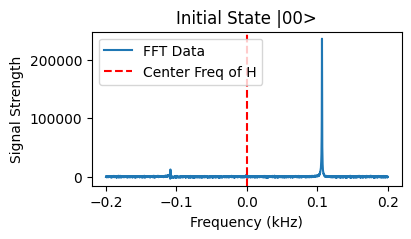

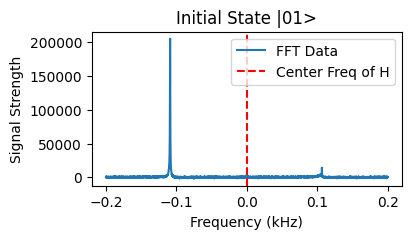

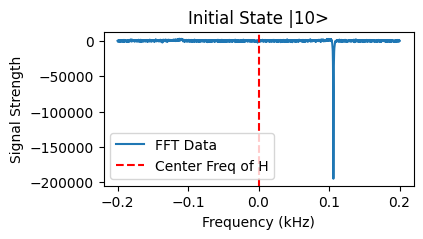

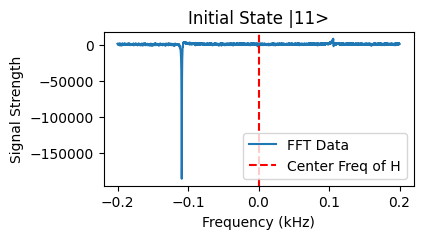

In [166]:
target_qubits = ['H']
states = ['00', '01', '10', '11']
initial_peaks = []

for i, state in enumerate(states):
    initial_peaks.append([])
    for qubit in target_qubits:
        xy_average = average_spectral_data_Ps(initial_state_data_map, 'no gate', qubit, state)
        avg_data = Data(qubit, temporal_avg_data=xy_average)
        # avg_data.phase_180_deg()
        # avg_data.flip_about_X()
        avg_data.plot_frequency_domain_data(f"Initial State |{state}>")
        initial_peaks[i].append(avg_data.integrate_peak(0, 0.02))
        initial_peaks[i].append(avg_data.integrate_peak(1, 0.02))



In [167]:
target_qubits = ['H']
states = ['00', '01', '10', '11']
Ps = ['P0', 'P1']

integrals_00 = []
integrals_01 = []
integrals_10 = []
integrals_11 = []

for i, state in enumerate(states):
    initial_peaks.append([])
    for qubit in target_qubits:
        for P in Ps:
            data = initial_state_data_map['no gate'][qubit][state][P]
            peak1 = data.integrate_peak(0, 0.02)
            peak2 = data.integrate_peak(1, 0.02)
            if state == '00':
                integrals_00.append(peak1)
                integrals_00.append(peak2)
            elif state == '01':
                integrals_01.append(peak1)
                integrals_01.append(peak2)
            elif state == '10':
                integrals_10.append(peak1)
                integrals_10.append(peak2)
            elif state == '11':
                integrals_11.append(peak1)
                integrals_11.append(peak2)
            else:
                print("state not found")

print(rho_from_peaks(integrals_00))
print(rho_from_peaks(integrals_01))
print(rho_from_peaks(integrals_10))
print(rho_from_peaks(integrals_11))



[]
[]
[]
[]
